In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import cvxpy as cp

## 数值算例说明
我们设计一个简单的时间序列. states这个向量长度为25, 每个点是可能值为0,1,2的随机数, 在三个值(代表不同模态)之间切换

再把states长度扩展为5000, 具体方法是把原先的25个点每个点重复200次, 这样保证了至少200步才会发生模态间的切换, 保证了切换频率不会过高

接下来再把0,1,2三个状态分别对应到三个不同的二维高斯分布. 把状态0变换到
$$
\mu_0 = \left(\begin{array}{l}
-4\\0
\end{array}
\right),\quad 

\Sigma_0=\left(\begin{array}{ll}
2 & 1.4\\
1.4 & 1.5
\end{array}\right)
$$

状态1变换到
$$
\mu_1 = \left(\begin{array}{l}
4\\-1
\end{array}
\right),\quad 

\Sigma_1=\left(\begin{array}{ll}
2 & -0.95\\
-0.95 & 1
\end{array}\right)
$$

状态2变换到
$$
\mu_2 = \left(\begin{array}{l}
-1\\-3
\end{array}
\right),\quad 

\Sigma_1=\left(\begin{array}{ll}
2 & 0.1\\
0.1 & 0.1
\end{array}\right)
$$


最终向量中各状态的实际数量:
状态 0: 3500
状态 1: 1000
状态 2: 500

最终向量中各状态的实际占比:
状态 0: 70.00%
状态 1: 20.00%
状态 2: 10.00%


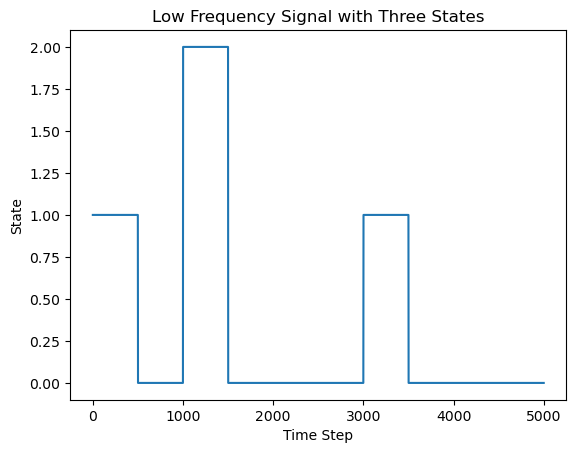

In [3]:
# 创建一个时间序列, 大致是在三个状态之间转换, 并控制转换的频率
torch.manual_seed(61)
n_steps = 5000

# 状态切换的次数, 意味着扩展成n_steps个点后, 大约会有num_segments次状态切换, 保证了每段至少有n_steps/num_segments个点
num_segments = 10

# 定义三个状态的权重(占比)
weights = torch.tensor([2.0, 1.0, 1.0])

# 根据weights的权重比例随机抽取num_segments个样本
low_frequency_signal = torch.multinomial(weights, num_segments, replacement=True)

# "拉伸"states, 使每段有n_steps/num_segments个点
segment_length = n_steps // num_segments
states = torch.repeat_interleave(low_frequency_signal, segment_length)

# 如果有余数，用最后一个状态的值填充，确保总长度为n_steps
remainder = n_steps % num_segments
if remainder != 0:
    states = torch.cat([states, torch.full((remainder,), int(low_frequency_signal[-1]))])


#   计算每个状态的实际数量和占比
actual_counts = torch.bincount(states, minlength=3) 
print("\n最终向量中各状态的实际数量:")
print(f"状态 0: {actual_counts[0].item()}")
print(f"状态 1: {actual_counts[1].item()}")
print(f"状态 2: {actual_counts[2].item()}")

actual_proportions = actual_counts.float() / n_steps
print("\n最终向量中各状态的实际占比:")
print(f"状态 0: {actual_proportions[0].item():.2%}")
print(f"状态 1: {actual_proportions[1].item():.2%}")
print(f"状态 2: {actual_proportions[2].item():.2%}")

plt.plot(states.numpy())
plt.title("Low Frequency Signal with Three States")
plt.xlabel("Time Step")
plt.ylabel("State")
plt.show()

In [4]:
mu_0 = torch.tensor([-4,0], dtype=torch.float32)
sigma_0 = torch.tensor([[2,1.4],[1.4,1.5]], dtype=torch.float32)

mu_1 = torch.tensor([4,-1], dtype=torch.float32)
sigma_1 = torch.tensor([[2,-0.95],[-0.95,1]], dtype=torch.float32)

mu_2 = torch.tensor([-1,-3], dtype=torch.float32)
sigma_2 = torch.tensor([[2,0.1],[0.1,0.1]], dtype=torch.float32)

In [5]:
torch.manual_seed(61)

dist_0 = torch.distributions.MultivariateNormal(loc=mu_0, covariance_matrix=sigma_0)
dist_1 = torch.distributions.MultivariateNormal(loc=mu_1, covariance_matrix=sigma_1)
dist_2 = torch.distributions.MultivariateNormal(loc=mu_2, covariance_matrix=sigma_2)


torch.manual_seed(101) # 使用一个不同的种子

# 创建一个空的张量来存放最终结果
Xt = torch.empty(n_steps, 2, dtype=torch.float32)

# 使用布尔掩码(boolean masking)进行高效采样和赋值，避免使用for循环
# 1. 找出状态为0的所有位置
mask_0 = (states == 0)
# 2. 在这些位置上，填充从第一个分布中抽取的样本
#    mask_0.sum() 会计算出需要抽取多少个样本
Xt[mask_0] = dist_0.sample((mask_0.sum(),))

# 对状态1和状态2重复此操作
mask_1 = (states == 1)
Xt[mask_1] = dist_1.sample((mask_1.sum(),))

mask_2 = (states == 2)
Xt[mask_2] = dist_2.sample((mask_2.sum(),))


print("最终输出的维度:", Xt.shape)

最终输出的维度: torch.Size([5000, 2])


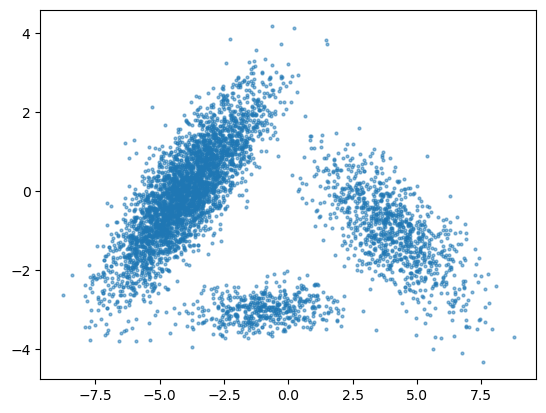

In [6]:
plt.plot(Xt[:,0], Xt[:,1], 'o', markersize=2, alpha=0.5)

In [7]:
# Random Fourier Feature

def sample_rff_gaussian(d, p, sigma):
    """ Draw a sample from the spectral density for a Gaussian kernel.
    Parameters:
    -----------
    d, int:         dimension of the state space for Gaussian kernel
    p, int:         number of samples from spectral density
    sigma, float:   bandwidth of the Gaussian kernel

    Returns:
    --------
    Omega (d, p):   p samples drawn from d-dimensional spectral density

    """

    return (1.0 / sigma) * np.random.randn(d, p)


def M_RFF_Koopman(X, Omega):
    
    phase = np.dot(X, Omega)  # shape: (n_steps, p)
    
    # 分别计算RFF的实部和虚部
    cos_features = np.cos(phase)  # shape: (n_steps, p)
    sin_features = np.sin(phase)  # shape: (n_steps, p)
    
    M = np.hstack([cos_features, sin_features])  # shape: (n_steps, 2*p)
    
    return M.T


In [8]:
# 用RFF变换Xt
d = Xt.shape[1]
p = 20   # RFF的基函数个数
sigma = 2

omega = sample_rff_gaussian(d, p, sigma)
transformed_Xt = M_RFF_Koopman(Xt, omega)

print(transformed_Xt.shape)  # (2*p, n_steps)

(40, 5000)


/tmp/ipykernel_316723/3231406522.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  phase = np.dot(X, Omega)  # shape: (n_steps, p)


In [9]:
# PCA Whitening, 加入特征函数1(x)

from scipy.linalg import eigh

def whitening_transform_pca(PhiX, tol, rmin=0):
    
    # centering the data
    
    mean_vec = np.mean(PhiX, axis=1, keepdims=True)
    X_centered = PhiX - mean_vec
    
    
    # covariance matrix
    cov_matrix = np.cov(X_centered)  
    
    # eigen decomposition
    eigenvalues, eigenvectors = eigh(cov_matrix)
    
    # sort in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # truncation
    ind = np.where(eigenvalues / eigenvalues[0] >= tol**2)[0]
    r = np.maximum(len(ind), rmin)
    
    selected_eigenvalues = eigenvalues[:r]
    selected_eigenvectors = eigenvectors[:, :r]
    
    # Whitening matrix
    L = selected_eigenvectors * (selected_eigenvalues**(-0.5))[None, :]
    
    return L, mean_vec

# 进行PCA Whitening
L_pca, mean_pca = whitening_transform_pca(transformed_Xt, tol=1e-4, rmin=0)
whitened_Xt = L_pca.T @ (transformed_Xt - mean_pca)

print(whitened_Xt.shape)  # (r, 10000)

(35, 5000)


In [10]:
# 验证协方差矩阵
cov_original = np.cov(transformed_Xt)
cov_whitened = np.cov(whitened_Xt)

print("RFF后协方差矩阵阶数: ", cov_original.shape)
print("白化变换后协方差矩阵阶数: ", cov_whitened.shape)

print("协方差矩阵对角线元素:", np.diag(cov_whitened))
print("协方差矩阵非对角线元素最大值:", np.max(np.abs(cov_whitened - np.diag(np.diag(cov_whitened)))))

RFF后协方差矩阵阶数:  (40, 40)
白化变换后协方差矩阵阶数:  (35, 35)
协方差矩阵对角线元素: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
协方差矩阵非对角线元素最大值: 2.9870895381792136e-10


In [11]:
# 加入特征函数1(x)
first_feature = np.ones(whitened_Xt.shape[1])
whitened_Xt = np.vstack([first_feature, whitened_Xt])
whitened_Xt.shape

(36, 5000)

In [12]:
# 定义L, gamma以及损失函数

class nonstation_generator(nn.Module):
    def __init__(self, n_features, n_steps, K, hidden_dim=64):
        super().__init__()
        
        self.n_features = n_features
        self.n_steps = n_steps
        self.K = K
        
        # generator function L
        self.L = nn.Parameter(
            torch.randn(K, n_features, n_features)  
        )
        
        # affiliation function gamma(t) 
        self.gamma_network = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, K)
        )   
        
    def init_gamma_from_prior(self, prior_gamma, lr=1e-3, max_iter=300):
        """
        使用先验gamma微调gamma_network
        
        Args:
            prior_gamma: 先验的gamma值 (K, n_steps)
            lr: 学习率
            max_iter: 最大迭代次数
        """
        prior_gamma = torch.tensor(prior_gamma, dtype=torch.float32)
        time_points = torch.linspace(0, 1, self.n_steps).unsqueeze(-1)
        
        # 只优化gamma_network
        optimizer = torch.optim.Adam(self.gamma_network.parameters(), lr=lr)
        
        for iteration in range(max_iter):
            optimizer.zero_grad()
            
            # 前向传播
            gamma_logits = self.gamma_network(time_points)
            gamma_pred = F.softmax(gamma_logits, dim=-1).T
            
            # 计算MSE损失
            loss = F.mse_loss(gamma_pred, prior_gamma)
            
            # 反向传播
            loss.backward()
            optimizer.step()
            
            # 打印损失
            if iteration % 100 == 0:
                print(f"初始化迭代 {iteration}: Loss = {loss.item():.6f}")      
    
    def forward(self):

        L = self.L
        
        time_points = torch.linspace(0, 1, self.n_steps).unsqueeze(-1)  # (n_steps, 1)
        gamma_logits = self.gamma_network(time_points)  # (n_steps, K)
        gamma = F.softmax(gamma_logits, dim=-1).T  
        
        return L, gamma

def koopman_loss_function(whitened_Xt, L, gamma, epsilon_gamma, epsilon_L):
    
    n_features, n_steps = whitened_Xt.shape
    K = L.shape[0]
    
    # 计算phi(x_n)和phi(x_n+1)
    phi_t = whitened_Xt[:, :-1]   # (n_features, n_steps-1)
    phi_t1 = whitened_Xt[:, 1:]   # (n_features, n_steps-1)
    
    phi_t_batch = phi_t.T.unsqueeze(0).expand(K, -1, -1)      # (K, n_steps-1, n_features)
    phi_t1_batch = phi_t1.T.unsqueeze(0).expand(K, -1, -1)    # (K, n_steps-1, n_features)
    
    predictions = torch.bmm(phi_t_batch, L)  # (K, n_steps-1, n_features)*(K, n_features, n_features) -> (K, n_steps-1, n_features)
    
    # norm(phi_n+1, L*phi_n)
    errors = phi_t1_batch - predictions
    squared_errors = torch.sum(errors**2, dim=-1)  # (K, n_steps-1)
    
    # \|\phi(x_{n+1})-L\phi(x_n)\|^2
    main_loss = (1/(n_steps-1)) * torch.sum(squared_errors * gamma[:, :-1])
    
    # 正则化项
    smoothness_loss = epsilon_gamma * (1/(n_steps-1)) * torch.sum((gamma[:, 1:] - gamma[:, :-1])**2)
    generator_loss = epsilon_L * torch.norm(L, p='fro')**2
    
    return main_loss + smoothness_loss + generator_loss

def train_koopman_model(whitened_Xt, K, prior_gamma=None, 
                        max_iter=1000, lr=1e-3, 
                        epsilon_gamma=0.01, epsilon_L=0.1,
                        init_lr=0.01, init_max_iter=500):
    
    whitened_Xt = torch.tensor(whitened_Xt, dtype=torch.float32)
    
    # 初始化模型
    n_features, n_steps = whitened_Xt.shape
      
    model = nonstation_generator(n_features, n_steps, K)
    
    # 如果提供先验gamma，进行初始化
    if prior_gamma is not None:
        print("使用先验gamma进行初始化...")
        model.init_gamma_from_prior(
            prior_gamma, 
            lr=init_lr, 
            max_iter=init_max_iter
        )
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # 训练
    for iteration in range(max_iter):
        optimizer.zero_grad()
        
        # 前向传播得到L和gamma(t)
        L, gamma = model()
        
        # 计算损失
        loss = koopman_loss_function(whitened_Xt, L, gamma, 
                                     epsilon_gamma=epsilon_gamma, 
                                     epsilon_L=epsilon_L)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 打印损失
        if iteration % 200 == 0:
            print(f"Iteration {iteration}: Loss = {loss.item():.6f}")
            
    
    return L.detach().numpy(), gamma.detach().numpy()


    

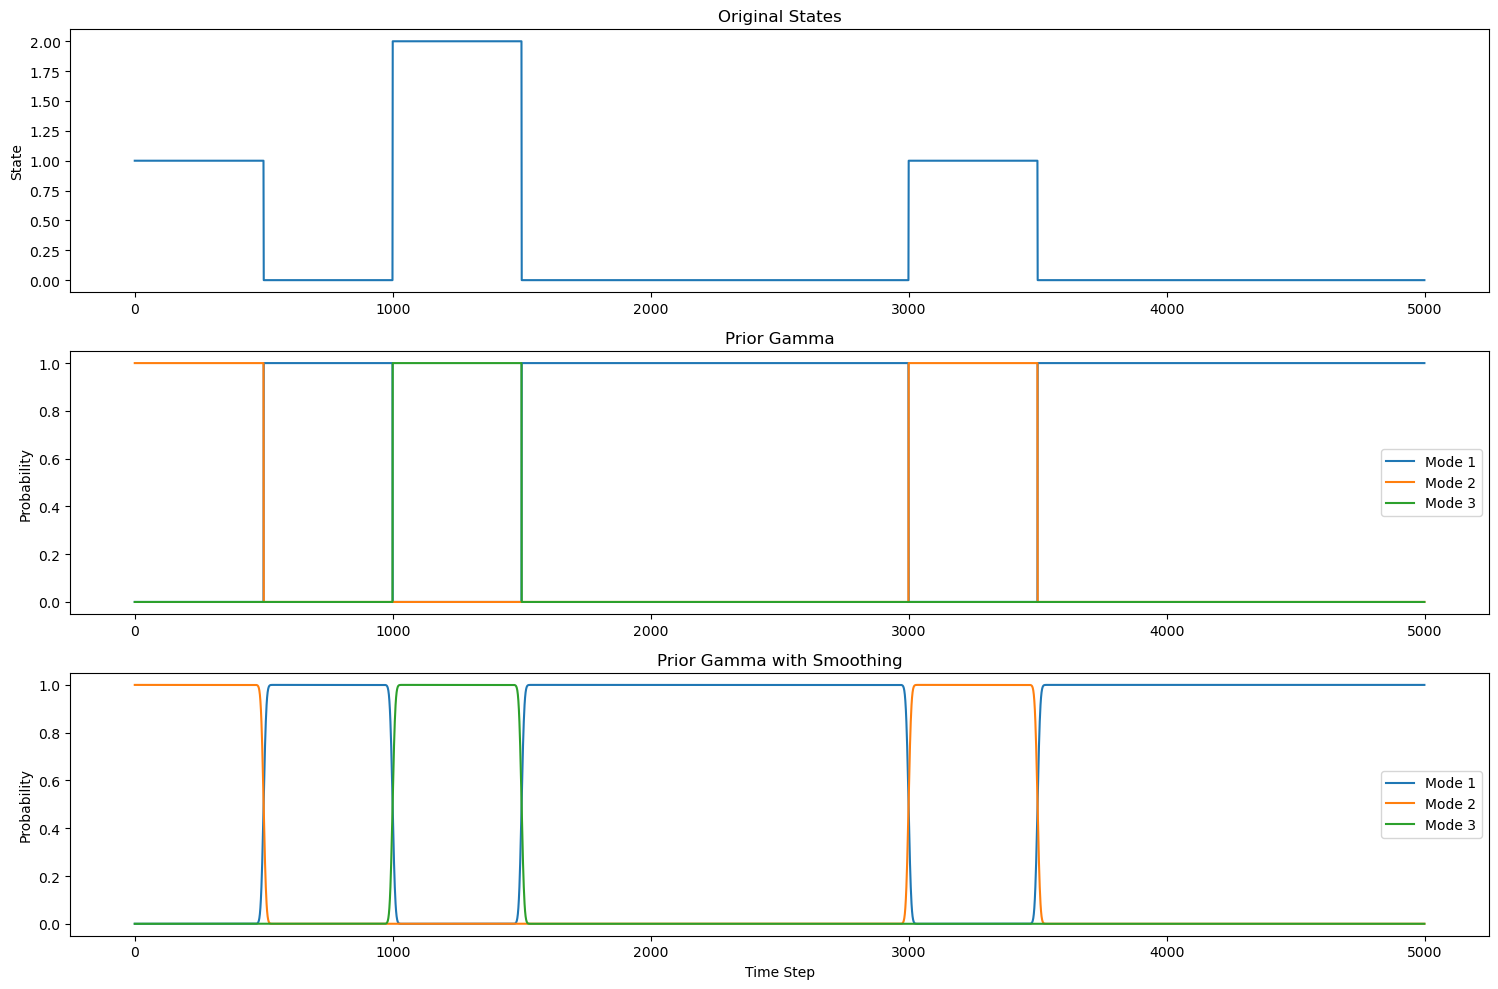

In [13]:
# 把states向量转换为prior_gamma
# 但这样的话只是$K=3$的情况, 如果$K$是其它值是不是就做不了这件事?
def states_to_prior_gamma(states, K=3, smoothing_window=50):
    """
    将状态向量转换为prior_gamma
    
    Args:
        states: 状态向量 (n_steps,)
        K: 状态数量
        smoothing_window: 平滑窗口大小，用于软化硬边界
    
    Returns:
        prior_gamma: (K, n_steps) 的先验gamma矩阵
    """
    n_steps = len(states)
    
    # 创建one-hot编码
    prior_gamma = torch.zeros(K, n_steps)
    for t in range(n_steps):
        prior_gamma[states[t], t] = 1.0
    
    # 应用高斯平滑来软化硬边界
    if smoothing_window > 1:
        from scipy.ndimage import gaussian_filter1d
        sigma = smoothing_window / 6.0  # 经验值
        
        for k in range(K):
            prior_gamma[k, :] = torch.tensor(
                gaussian_filter1d(prior_gamma[k, :].numpy(), sigma=sigma)
            )
        
        # 重新归一化
        prior_gamma = prior_gamma / prior_gamma.sum(dim=0, keepdim=True)
    
    return prior_gamma.numpy()


# 以$K=3$为例转换为prior_gamma
K = 3
prior_gamma_hard = states_to_prior_gamma(states, K=K, smoothing_window=1)  # 硬边界
prior_gamma_soft = states_to_prior_gamma(states, K=K, smoothing_window=50)  # 软边界

# 可视化比较
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# 原始states
axes[0].plot(states.numpy())
axes[0].set_title("Original States")
axes[0].set_ylabel("State")

# hard prior_gamma
for k in range(K):
    axes[1].plot(prior_gamma_hard[k, :], label=f'Mode {k+1}')
axes[1].set_title("Prior Gamma")
axes[1].set_ylabel("Probability")
axes[1].legend()

# 软边界prior_gamma
for k in range(K):
    axes[2].plot(prior_gamma_soft[k, :], label=f'Mode {k+1}')
axes[2].set_title("Prior Gamma with Smoothing")
axes[2].set_ylabel("Probability")
axes[2].set_xlabel("Time Step")
axes[2].legend()

plt.tight_layout()
plt.show()



In [14]:
# 对不同的$K$进行测试

def explore_different_k(whitened_Xt, 
                        K_range=[3, 4, 5], 
                        max_iter=8000, 
                        epsilon_gamma=0.001, 
                        epsilon_L=0.1,
                        prior_gamma=None
                        ):
    
    results = {}
    
    for K in K_range:
        print(f"\n K = {K}")
        
        prior_gamma = prior_gamma.get(K, None) if prior_gamma else None
        
        # 训练模型
        L, gamma = train_koopman_model(
            whitened_Xt, 
            K=K, 
            prior_gamma=prior_gamma,
            max_iter=max_iter,
            epsilon_gamma=epsilon_gamma,
            epsilon_L=epsilon_L
        )
        
        # 计算损失
        loss = koopman_loss_function(
            torch.tensor(whitened_Xt, dtype=torch.float32), 
            torch.tensor(L, dtype=torch.float32), 
            torch.tensor(gamma, dtype=torch.float32), 
            epsilon_gamma=epsilon_gamma, 
            epsilon_L=epsilon_L
        )
        
        # 存储结果
        results[K] = {
            'L': L,
            'gamma': gamma,
            'loss': loss.item()
        }
        
        # 可视化gamma(t)
        plt.figure(figsize=(15, 4))
        plt.title(f'Gamma(t) for K = {K} (Loss: {loss.item():.4f})')
        for k in range(K):
            plt.plot(gamma[k, :], label=f'Mode {k+1}')
        plt.legend()
        plt.xlabel('Time Step')
        plt.ylabel('Affiliation')
        plt.show()
    
    return results


 K = 3
使用先验gamma进行初始化...


初始化迭代 0: Loss = 0.214903
初始化迭代 100: Loss = 0.047871
初始化迭代 200: Loss = 0.014281
初始化迭代 300: Loss = 0.009081
初始化迭代 400: Loss = 0.007090
Iteration 0: Loss = 1714.857544
Iteration 200: Loss = 1141.554321
Iteration 400: Loss = 776.888672
Iteration 600: Loss = 546.508118
Iteration 800: Loss = 397.115479
Iteration 1000: Loss = 297.804382
Iteration 1200: Loss = 229.846527
Iteration 1400: Loss = 181.912811
Iteration 1600: Loss = 147.126190
Iteration 1800: Loss = 121.254906
Iteration 2000: Loss = 101.631363
Iteration 2200: Loss = 86.522217
Iteration 2400: Loss = 74.763046
Iteration 2600: Loss = 65.545212
Iteration 2800: Loss = 58.289562
Iteration 3000: Loss = 52.569748
Iteration 3200: Loss = 48.064159
Iteration 3400: Loss = 44.524914
Iteration 3600: Loss = 41.757324
Iteration 3800: Loss = 39.606106
Iteration 4000: Loss = 37.946011
Iteration 4200: Loss = 36.675354
Iteration 4400: Loss = 35.711468
Iteration 4600: Loss = 34.987206
Iteration 4800: Loss = 34.448345
Iteration 5000: Loss = 34.051388
Ite

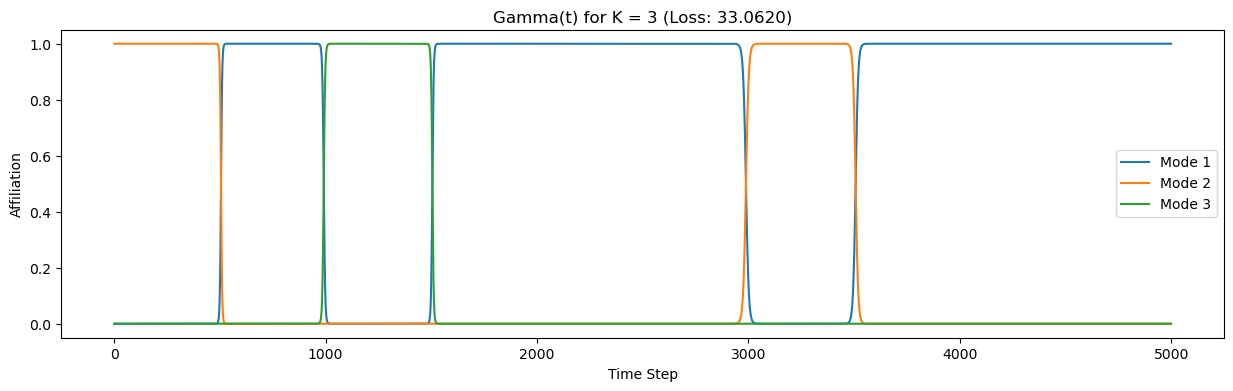

In [15]:
results = explore_different_k(
    whitened_Xt, 
    K_range=[3],  # 只使用K=3
    prior_gamma={3: states_to_prior_gamma(states, smoothing_window=1)}
)

## Finite Element Method计算gamma_t

# 计算loss

def FEM_loss_function(whitened_Xt, L, gamma, quadratic_matrix, FEM_interval=100, epsilon_gamma=0.001, epsilon_L=0.01):
    
    """
    gamma: (K, hat_N)
    quadratic_matrix: (hat_N, hat_N), 三对角矩阵
    
    """
    n_features, n_steps = whitened_Xt.shape
    K = L.shape[0]
    
    # 根据 FEM_interval 选择格点
    selected_indices = list(range(0, n_steps, FEM_interval))
    
    # 使用选定的格点
    selected_Xt = whitened_Xt[:, selected_indices]
    
    hat_N = gamma.shape[0] // K
    
    # 计算phi(x_n)和phi(x_n+1)
    phi_t = selected_Xt[:, :-1]   # (n_features, n_steps-1)
    phi_t1 = selected_Xt[:, 1:]   # (n_features, n_steps-1)
    
    
    phi_t_batch = phi_t.T.unsqueeze(0).expand(K, -1, -1)      # (K, n_steps-1, n_features)
    phi_t1_batch = phi_t1.T.unsqueeze(0).expand(K, -1, -1)    # (K, n_steps-1, n_features)
    
    predictions = torch.bmm(phi_t_batch, L)  # (K, n_steps-1, n_features)*(K, n_features, n_features) -> (K, n_steps-1, n_features)
    
    # norm(phi_n+1, L*phi_n)
    errors = phi_t1_batch - predictions
    squared_errors = torch.sum(errors**2, dim=-1)  # (K, n_steps-1)
        
    # \|\phi(x_{n+1})-L\phi(x_n)\|^2
    main_loss = (1/(hat_N-1)) * torch.sum(squared_errors * gamma[:,1:])
    
    # 正则化项, 注意在gamma是(K, hat_N)的情况下, 这一项是gamma^T H gamma的trace
    smoothness_loss = epsilon_gamma * torch.trace(gamma @ quadratic_matrix @ gamma.T) / hat_N
    # smoothness_loss = epsilon_gamma * torch.sum((gamma @ quadratic_matrix) * gamma) / hat_N
    
    generator_loss = epsilon_L * torch.norm(L, p='fro')**2
    
    return main_loss + smoothness_loss + generator_loss

In [16]:
FEM_interval = 10    #FEM网格两个格点的间隔
hat_N = n_steps // FEM_interval   #此时的格点数
K = 3

# loss function涉及到的矩阵
# H: (hat_N, hat_N) 的三对角矩阵

def building_quadratic_matrix(hat_N):
    # 构建三对角矩阵H
    H = torch.diag(torch.ones(hat_N)*2) + torch.diag(torch.ones(hat_N-1)*(-1), 1) + torch.diag(torch.ones(hat_N-1)*(-1), -1)
    H[[0, hat_N-1], [0, hat_N-1]] = 1
    return H

H = building_quadratic_matrix(hat_N)
print(H)


tensor([[ 1., -1.,  0.,  ...,  0.,  0.,  0.],
        [-1.,  2., -1.,  ...,  0.,  0.,  0.],
        [ 0., -1.,  2.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  2., -1.,  0.],
        [ 0.,  0.,  0.,  ..., -1.,  2., -1.],
        [ 0.,  0.,  0.,  ...,  0., -1.,  1.]])


In [17]:
# Bridge regression for L_FEM
def update_generator(phi_t, phi_t1, weights_k, eps_L):
    # phi_t, phi_t1: (n_feature, M) numpy
    n_feature, M = phi_t.shape
    W = np.diag(weights_k)  # (M, M)
    XWXt = phi_t @ W @ phi_t.T  # (n_feature, n_feature)
    YWXt = phi_t1 @ W @ phi_t.T  # (n_feature, n_feature)
    reg = eps_L * np.eye(n_feature)
    inv_term = np.linalg.inv(XWXt + reg + 1e-12 * np.eye(n_feature))
    Lk = YWXt @ inv_term
    return Lk

In [18]:
# 用quadratic programming优化gamma

def update_gamma_qp(e, quadratic_matrix, epsilon_gamma, gamma_init=None, device='cpu', verbose=False):
    """
    e: (K, M) numpy, error from each generator L_k
    gamma: (K, hat_N), hat_N = M+1
    QP constraints: gamma >= 0, sum_k gamma[k, n] = 1 for each column n
    """

    K, M = e.shape
    hat_N = quadratic_matrix.shape[0]
    assert hat_N == M + 1

    M_inv = 1.0 / float(M)

    # gamma 变量，一次性展开成向量
    gamma = cp.Variable((K, hat_N))

    # 主损失线性项
    main_loss = M_inv * cp.sum(cp.multiply(e, gamma[:,:-1]))

    # 平滑损失 QP 二次项
    smooth_loss = 0
    for k in range(K):
        gk = gamma[k, :]
        smooth_loss += cp.quad_form(gk, quadratic_matrix)  # gk^T A gk

    smooth_loss *= (epsilon_gamma * M_inv)

    # 总损失
    objective = cp.Minimize(main_loss + smooth_loss)

    # 约束条件
    constraints = []
    # 非负性
    constraints += [gamma >= 0]
    # 每列归一化（原代码 softmax dim=0）
    for n in range(hat_N):
        constraints.append(cp.sum(gamma[:, n]) == 1.0)

    # 求解 QP
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP, verbose=verbose)  

    gamma_val = gamma.value
    return gamma_val


In [19]:
def update_gamma_Adam(e, quadratic_matrix, epsilon_gamma, gamma_init=None, n_inner_steps=100, lr=1e-3, device='cpu', verbose=False):
    """
    e: (K, M) numpy, hat_N = M+1
    gamma parameterized by theta (K, hat_N) with column-wise softmax: gamma[:,j] = softmax(theta[:,j])
    We optimize theta by gradient descent (Adam) to minimize objective with L fixed.
    """
    K, M = e.shape
    hat_N = quadratic_matrix.shape[0]
    assert hat_N == M + 1

    # initialize theta so softmax(theta) = gamma_init if provided
    if gamma_init is None:
        theta_np = np.zeros((K, hat_N), dtype=np.float32)
    else:
        eps = 1e-8
        gamma_safe = np.clip(gamma_init, eps, 1.0)
        theta_np = np.log(gamma_safe)  # not unique but reasonable init
    theta = torch.tensor(theta_np, dtype=torch.float32, requires_grad=True, device=device)

    A_torch = torch.tensor(quadratic_matrix, dtype=torch.float32, device=device)
    e_full = np.zeros((K, hat_N))
    e_full[:, :-1] = e
    e_vec = torch.tensor(e_full, dtype=torch.float32, device=device)

    optimizer = torch.optim.Adam([theta], lr=lr)

    M_inv = 1.0 / float(M)

    for it in range(n_inner_steps):
        optimizer.zero_grad()
        gamma = torch.softmax(theta, dim=0)  # softmax over modes for each column: dim=0
        main_loss = M_inv * torch.sum(e_vec * gamma)   # e_vec has zeros in first col
        smooth_loss = (epsilon_gamma * M_inv) * torch.einsum('kn,nm,km->', gamma, A_torch, gamma)
        loss = main_loss + smooth_loss
        loss.backward()
        optimizer.step()

        if verbose and (it % 50 == 0 or it == n_inner_steps-1):
            print(f" softmax inner iter {it:04d} | loss {loss.item():.6e} | main {main_loss.item():.6e} | smooth {smooth_loss.item():.6e}")

    gamma_new = torch.softmax(theta, dim=0).detach().cpu().numpy()
    return gamma_new

In [20]:
def train_fem(whitened_Xt, K, gamma_init=None, FEM_interval=100, epsilon_gamma=0.001,
                          epsilon_L=1e-3, max_iters=100, tol=1e-6, verbose=True):
    """
    whitened_Xt: torch tensor shape (n_features, n_steps)
    K: number of modes
    Returns: L (K, n_features, n_features) , gamma (K, M)
    """
    device = whitened_Xt.device if isinstance(whitened_Xt, torch.Tensor) else torch.device('cpu')
    Xt = whitened_Xt.cpu().numpy() if isinstance(whitened_Xt, torch.Tensor) else whitened_Xt
    n_features, n_steps = Xt.shape

    # 选择格点
    selected_indices = list(range(0, n_steps, FEM_interval))
    if selected_indices[-1] != n_steps - 1:
        # 保证包含最后一个点
        selected_indices.append(n_steps - 1)
    selected_Xt = Xt[:, selected_indices]  # (n_features, N_selected)
    hat_N = selected_Xt.shape[1]
    M = hat_N - 1  

    phi_t = selected_Xt[:, :-1]   # (n_features, M)
    phi_t1 = selected_Xt[:, 1:]   # (n_features, M)

    # 初始化 gamma: 每个mode等概率
    # gamma最后一列不参与main_loss
    if gamma_init is None:
        gamma = np.ones((K, hat_N)) / K
        
    else:
        gamma = gamma_init

    # 初始化 L: 单位矩阵
    L = np.zeros((K, n_features, n_features))
    for k in range(K):
        L[k] = np.eye(n_features)

    # 构造正则化项中的二次型矩阵
    quadratic_matrix = building_quadratic_matrix(hat_N)

    prev_obj = np.inf
    for it in range(max_iters):
        # ----- Step 1: update L given gamma -----
        for k in range(K):
            weights_k = gamma[k, :M]  # shape (hat_N,)
            L[k] = update_generator(phi_t, phi_t1, weights_k, epsilon_L)

        # ----- compute errors e_{k,n} -----
        # e_{k,n} = ||phi_t1[:,n] - L_k @ phi_t[:,n]||^2
        e = np.zeros((K, M))
        for k in range(K):
            preds = L[k] @ phi_t  # (n_features, M)
            dif = phi_t1 - preds
            e[k, :] = np.sum(dif ** 2, axis=0)

        # ----- Step 2: update gamma given L -----
        gamma = update_gamma_qp(e, quadratic_matrix, epsilon_gamma, gamma_init=gamma, verbose=verbose)
        # gamma = update_gamma_Adam(e, quadratic_matrix, epsilon_gamma, gamma_init=gamma, n_inner_steps=100)

        # ----- 计算训练目标值供监控 -----
        main_loss = (1.0 / M) * np.sum(e * gamma[:, :-1])  
        smooth_loss = (epsilon_gamma / M) * np.einsum('kn,nm,km->', gamma, quadratic_matrix, gamma)  # trace(gamma^T A gamma)
        gen_loss = epsilon_L * np.sum(L ** 2)
        total_loss = main_loss + smooth_loss + gen_loss

        if verbose:
            print(f"Iter {it:03d} | total_loss {total_loss:.6e} | main {main_loss:.6e} | smooth {smooth_loss:.6e} | gen {gen_loss:.6e}")

        # 收敛判定
        if abs(prev_obj - total_loss) < tol:
            if verbose:
                print("Converged (tol reached).")
            break
        prev_obj = total_loss
        info = {'loss': total_loss, 'main': main_loss, 'smooth': smooth_loss, 'gen': gen_loss, 'iterations': it+1}
        
    
    return L, gamma, info

In [21]:
zz = np.arange(0,20)
zz[::2]


array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])

In [22]:
prior_gamma={3: states_to_prior_gamma(states, smoothing_window=1)}
prior_gamma = prior_gamma.get(K, None)

indices = list(range(0, n_steps, FEM_interval))
if indices[-1] != n_steps-1:  
    indices.append(n_steps-1)

gamma_init = prior_gamma[:,indices]

L, gamma, info = train_fem(whitened_Xt, K=3, gamma_init=gamma_init, FEM_interval=100, epsilon_gamma=1e-2,
                          epsilon_L=1e-2, max_iters=500, tol=1e-8, verbose=True)

(CVXPY) Oct 16 11:35:41 AM: Your problem has 153 variables, 204 constraints, and 0 parameters.
(CVXPY) Oct 16 11:35:41 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 16 11:35:41 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 16 11:35:41 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 16 11:35:41 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Oct 16 11:35:41 AM: Compiling problem (target solver=OSQP).
(CVXPY) Oct 16 11:35:41 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Oct 16 11:35:41 AM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 16 11:35:41 AM: Applying reduction Qp2SymbolicQp
(CVXPY) Oct 16 11:35:41 AM: Applying reduction QpMatrixStuffing
(CVXPY) Oct 16 11:35:41 AM: Applying reduction OSQP
(CVXPY) Oct 16 11:35:41 AM: Finished problem compilation 

                                     CVXPY                                     
                                     v1.7.3                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 306, constraints m = 357
          nnz(P) + nnz(A) = 915
settings: algebra = Built-in,
          OSQPInt =

(CVXPY) Oct 16 11:35:41 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Oct 16 11:35:41 AM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 16 11:35:41 AM: Applying reduction Qp2SymbolicQp
(CVXPY) Oct 16 11:35:41 AM: Applying reduction QpMatrixStuffing
(CVXPY) Oct 16 11:35:41 AM: Applying reduction OSQP
(CVXPY) Oct 16 11:35:41 AM: Finished problem compilation (took 4.827e-02 seconds).
(CVXPY) Oct 16 11:35:41 AM: Invoking solver OSQP  to obtain a solution.
(CVXPY) Oct 16 11:35:41 AM: Problem status: optimal
(CVXPY) Oct 16 11:35:41 AM: Optimal value: 3.420e+00
(CVXPY) Oct 16 11:35:41 AM: Compilation took 4.827e-02 seconds
(CVXPY) Oct 16 11:35:41 AM: Solver (including time spent in interface) took 1.065e-02 seconds
(CVXPY) Oct 16 11:35:41 AM: Your problem has 153 variables, 204 constraints, and 0 parameters.
(CVXPY) Oct 16 11:35:41 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 16 11:35:41 AM: (If you need to solve this proble

-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 306, constraints m = 357
          nnz(P) + nnz(A) = 915
settings: algebra = Built-in,
          OSQPInt = 8 bytes, OSQPFloat = 8 bytes,
          linear system solver = QDLDL v0.1.8,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive: 50 iterations),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25, duality gap: on),
          time_limit: 1.00e+10 sec,
     

(CVXPY) Oct 16 11:35:41 AM: Applying reduction OSQP
(CVXPY) Oct 16 11:35:41 AM: Finished problem compilation (took 5.500e-02 seconds).
(CVXPY) Oct 16 11:35:41 AM: Invoking solver OSQP  to obtain a solution.
(CVXPY) Oct 16 11:35:41 AM: Problem status: optimal
(CVXPY) Oct 16 11:35:41 AM: Optimal value: 2.682e+00
(CVXPY) Oct 16 11:35:41 AM: Compilation took 5.500e-02 seconds
(CVXPY) Oct 16 11:35:41 AM: Solver (including time spent in interface) took 8.995e-03 seconds


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 306, constraints m = 357
          nnz(P) + nnz(A) = 915
settings: algebra = Built-in,
          OSQPInt = 8 bytes, OSQPFloat = 8 bytes,
          linear system solver = QDLDL v0.1.8,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive: 50 iterations),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25, duality gap: on),
          time_limit: 1.00e+10 sec,
     

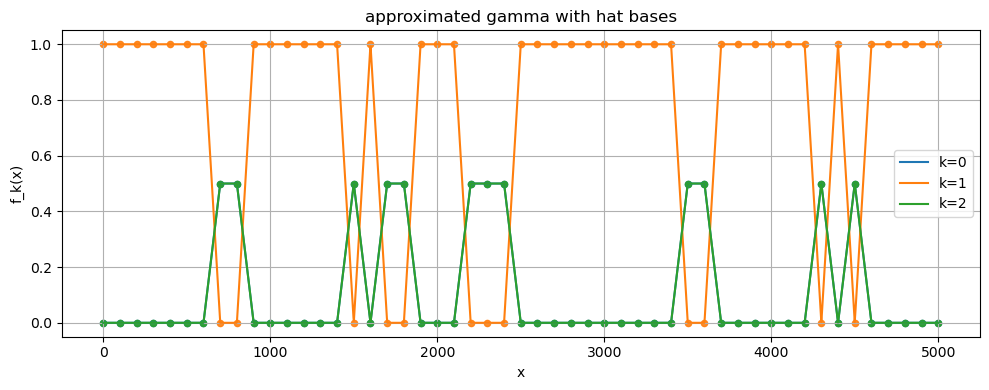

In [23]:
def plot_gamma_hat_functions(gamma, x_nodes=None, num_plot_points=2000,
                             show_nodes=True, title=None, figsize=(10,4)):
    
    gamma = np.asarray(gamma)
    if gamma.ndim != 2:
        raise ValueError("gamma must be 2D array (K, hat_N)")
    K, hat_N = gamma.shape

    if x_nodes is None:
        x_nodes = np.linspace(0, 5000, hat_N)  
    else:
        x_nodes = np.asarray(x_nodes)
    if x_nodes.shape[0] != hat_N:
        raise ValueError("x_nodes length must match gamma columns (hat_N)")

    x_plot = np.linspace(x_nodes[0], x_nodes[-1], num_plot_points)

    # Build hat-basis evaluations
    Phi = np.zeros((hat_N, num_plot_points), dtype=float)
    for n in range(hat_N):
        xn = x_nodes[n]
        if n == 0:
            x_left, x_right = x_nodes[0], x_nodes[1]
            denom = (x_right - x_left) if x_right != x_left else 1.0
            mask = (x_plot >= x_left) & (x_plot <= x_right)
            Phi[n, mask] = 1.0 - (x_plot[mask] - x_left) / denom
        elif n == hat_N - 1:
            x_left, x_right = x_nodes[-2], x_nodes[-1]
            denom = (x_right - x_left) if x_right != x_left else 1.0
            mask = (x_plot >= x_left) & (x_plot <= x_right)
            Phi[n, mask] = (x_plot[mask] - x_left) / denom
        else:
            x_left, x_center, x_right = x_nodes[n-1], x_nodes[n], x_nodes[n+1]
            denom_l = (x_center - x_left) if x_center != x_left else 1.0
            denom_r = (x_right - x_center) if x_right != x_center else 1.0
            mask_l = (x_plot >= x_left) & (x_plot <= x_center)
            mask_r = (x_plot >= x_center) & (x_plot <= x_right)
            Phi[n, mask_l] = (x_plot[mask_l] - x_left) / denom_l
            Phi[n, mask_r] = 1.0 - (x_plot[mask_r] - x_center) / denom_r

    # Compute fk(x) = sum_n gamma[k,n] * phi_n(x)
    F = gamma @ Phi  # shape (K, num_plot_points)

    plt.figure(figsize=figsize)
    cmap = plt.get_cmap('tab10')
    for k in range(K):
        plt.plot(x_plot, F[k], label=f'k={k}', color=cmap(k % 10))
    if show_nodes:
        for k in range(K):
            plt.scatter(x_nodes, gamma[k], s=20, marker='o', color=cmap(k % 10), alpha=0.9)
    plt.xlabel('x')
    plt.ylabel('f_k(x)')
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage with synthetic gamma (if you don't provide real gamma)
if __name__ == "__main__":
    
    plot_gamma_hat_functions(gamma, title='approximated gamma with hat bases')


(CVXPY) Oct 16 11:35:41 AM: Your problem has 153 variables, 204 constraints, and 0 parameters.
(CVXPY) Oct 16 11:35:41 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 16 11:35:41 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 16 11:35:41 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 16 11:35:41 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Oct 16 11:35:41 AM: Compiling problem (target solver=OSQP).
(CVXPY) Oct 16 11:35:41 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Oct 16 11:35:42 AM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 16 11:35:42 AM: Applying reduction Qp2SymbolicQp
(CVXPY) Oct 16 11:35:42 AM: Applying reduction QpMatrixStuffing
(CVXPY) Oct 16 11:35:42 AM: Applying reduction OSQP
(CVXPY) Oct 16 11:35:42 AM: Finished problem compilation 

                                     CVXPY                                     
                                     v1.7.3                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 306, constraints m = 357
          nnz(P) + nnz(A) = 915
settings: algebra = Built-in,
          OSQPInt =

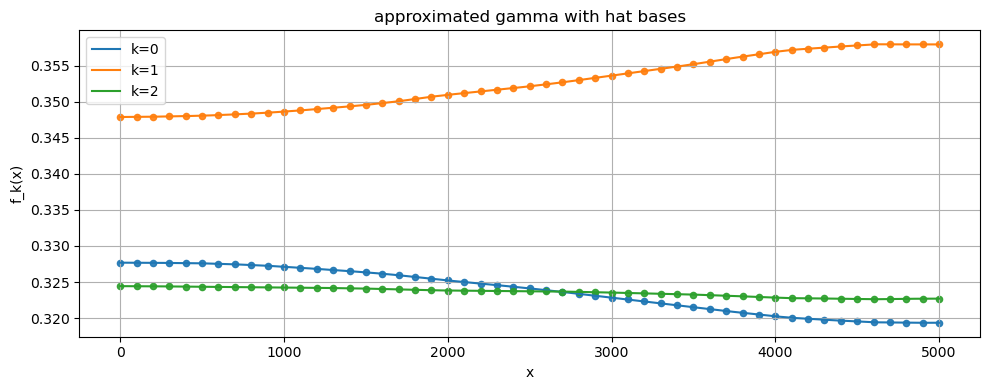

In [24]:
L, gamma, info = train_fem(whitened_Xt, K=3, gamma_init=None, FEM_interval=100, epsilon_gamma=1e-2,
                          epsilon_L=1e-3, max_iters=500, tol=1e-8, verbose=True)

plot_gamma_hat_functions(gamma, title='approximated gamma with hat bases')


## 在训练一段时间后再加入gamma的正则化项